<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '/media/Data/Dev/Projects/data-science/6_final_project/notes'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    data_matrix = []
    raw_data = []
    
    file_list = sorted(glob(path_to_csv_files + '/*.csv'))
    
    for f in tqdm(file_list, desc='Read data'):
        data = pd.read_csv(f)
        row = []
        for j, k in zip(data['timestamp'], data['site']):
            row += [(j, k)]
        raw_data += [row]
    
    with open(site_freq_path, 'rb') as f:
        site_dict = pickle.load(f)
    
           
    for i, v in enumerate(tqdm(raw_data, desc='Create data set')):
        for j in np.arange(0, len(v), window_size):
            row = []
            times = []
            for k in np.arange(session_length):
                                
                try:
                    row += [site_dict[v[j+k][1]][0]]
                    times += [v[j+k][0]]
                
                except:
                    row += [0]
                    
                               
            time_min = datetime.strptime(min(times), '%Y-%m-%d %H:%M:%S')
            time_max = datetime.strptime(max(times), '%Y-%m-%d %H:%M:%S')
            
            if (0 in row): unique_sites = len(set(row)) - 1
            else: unique_sites = len(set(row))
            
            start_hour = time_min.hour
            
            day_of_week = time_min.date().weekday()
            
            row += [(time_max-time_min).seconds, unique_sites, start_hour, day_of_week, i+1]
                            
            data_matrix += [row]
                
    data_set = pd.DataFrame (data_matrix, columns=feature_names)
    
    return data_set

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

Create data set: 100%|██████████| 3/3 [00:00<00:00, 1233.14it/s]


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,4,2,2,10,2,1,9,6,7,11,7998,8,9,4,1
1,4,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,4,2,5,5,2,0,0,0,0,0,7935,3,9,4,2
3,3,1,2,1,2,1,1,6,8,3,7998,5,9,4,3
4,3,1,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Create data set: 100%|██████████| 10/10 [00:00<00:00, 17.05it/s]


CPU times: user 816 ms, sys: 52 ms, total: 868 ms
Wall time: 829 ms


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,193,586,134,3,134,134,3,134,204,134,33,5,8,4,1
1,415,192,703,255,134,31,398,4025,220,55,284,10,8,4,1
2,55,3,55,55,5,293,415,336,932,55,258,7,8,4,1
3,482,4036,482,55,55,55,55,1004,199,123,30,6,8,4,1
4,344,55,5,4499,260,211,3385,2508,702,2508,6,9,8,4,1


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Create data set: 100%|██████████| 150/150 [00:05<00:00, 26.93it/s]


CPU times: user 7.12 s, sys: 536 ms, total: 7.66 s
Wall time: 7.42 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users.iloc[:, -5:-1].values
new_features_150users = train_data_150users.iloc[:, -5:-1].values

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [11]:
id_name_dict = {1: 'Mary-Kate', 2: 'Ashley', 3: 'Lindsey', 4: 'Naomi', 5: 'Avril',
               6: 'Bob', 7: 'Bill', 8: 'John', 9: 'Dick', 10: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [12]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

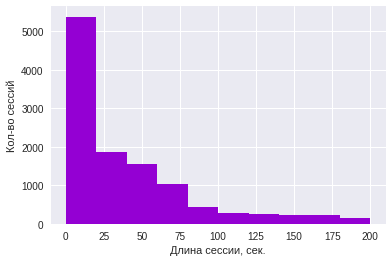

In [13]:
axes = train_data_10users['session_timespan'][train_data_10users.session_timespan <= 200].hist(color = 'darkviolet')
axes.set_ylabel ('Кол-во сессий')
axes.set_xlabel ('Длина сессии, сек.')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

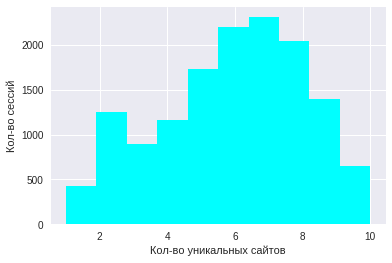

In [14]:
axes = train_data_10users['#unique_sites'].hist(color = 'aqua')
axes.set_ylabel ('Кол-во сессий')
axes.set_xlabel ('Кол-во уникальных сайтов')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

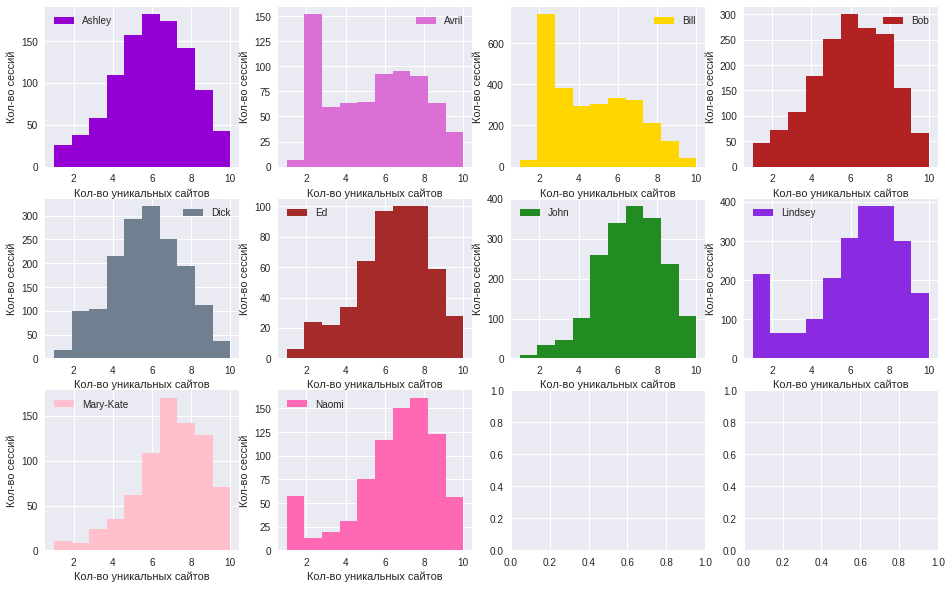

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    axes[idx//4, idx%4].set_ylabel ('Кол-во сессий')
    axes[idx//4, idx%4].set_xlabel ('Кол-во уникальных сайтов')
    sub_df['#unique_sites'].hist(ax=axes[idx//4, idx%4], color=color_dic[user], label=user)
    axes[idx//4, idx%4].legend()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

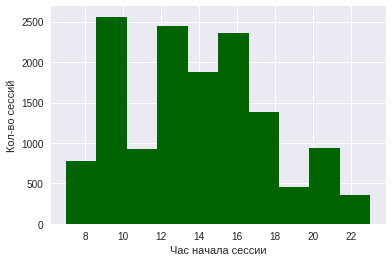

In [16]:
axes = train_data_10users['start_hour'].hist(color = 'darkgreen')
axes.set_ylabel ('Кол-во сессий')
axes.set_xlabel ('Час начала сессии')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

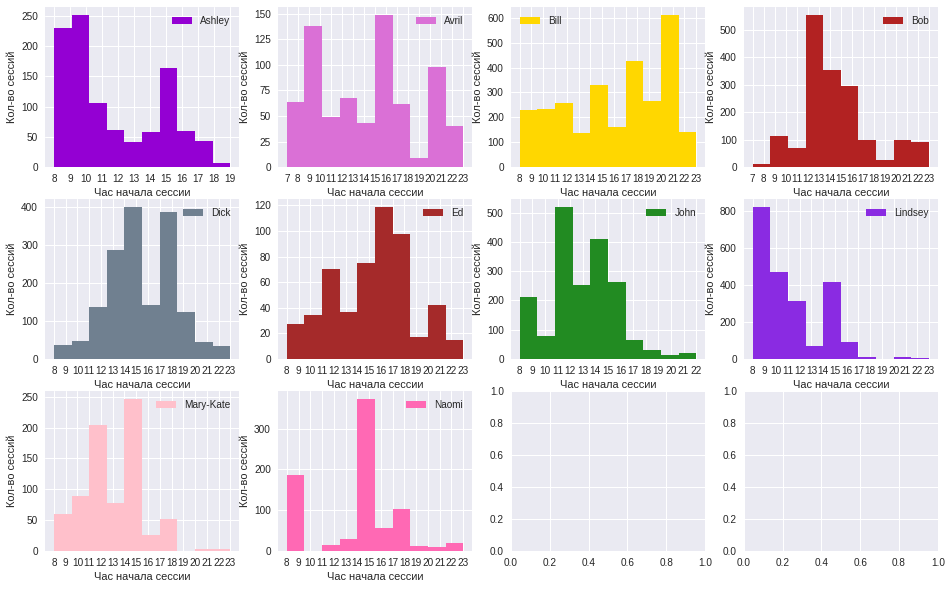

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    axes[idx//4, idx%4].set_ylabel ('Кол-во сессий')
    axes[idx//4, idx%4].set_xlabel ('Час начала сессии')
    axes[idx//4, idx%4].set_xticks([i for i in range(24)])
    sub_df['start_hour'].hist(ax=axes[idx//4, idx%4], color=color_dic[user], label=user)
    axes[idx//4, idx%4].legend()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

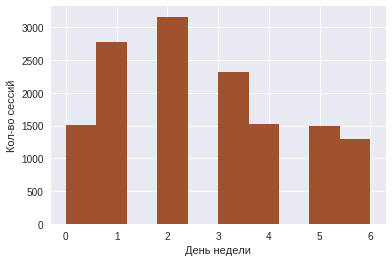

In [18]:
axes = train_data_10users['day_of_week'].hist(color = 'sienna')
axes.set_ylabel ('Кол-во сессий')
axes.set_xlabel ('День недели')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

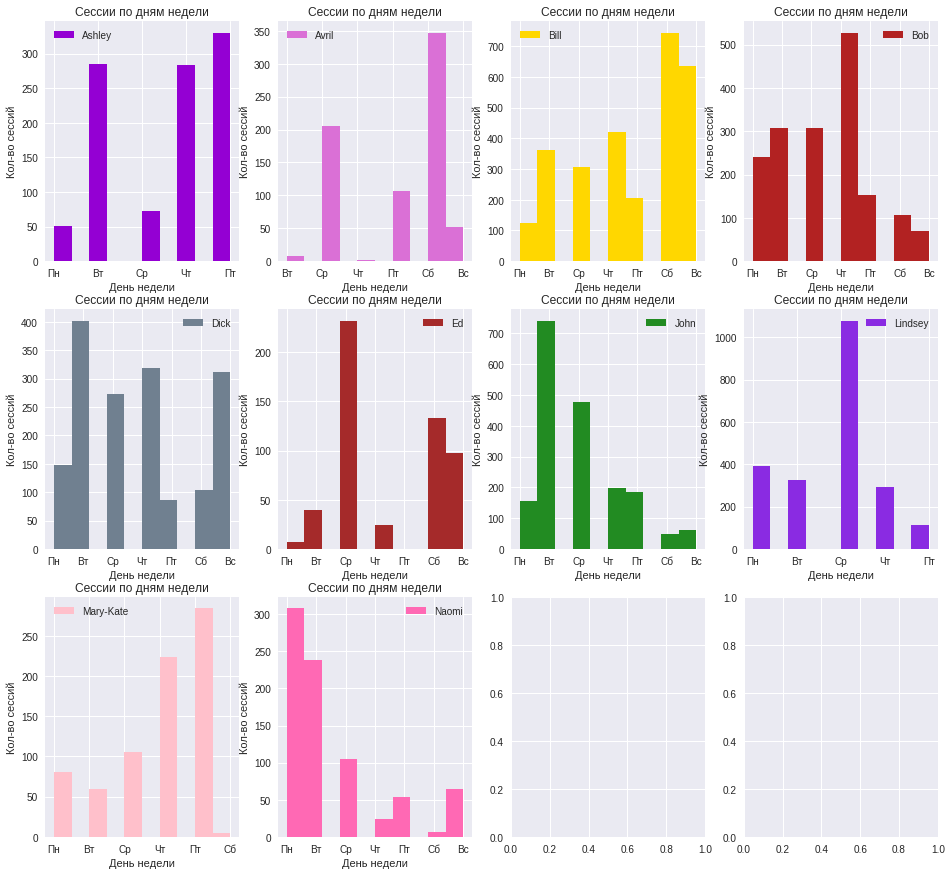

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 15))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    axes[idx//4, idx%4].set_ylabel ('Кол-во сессий')
    axes[idx//4, idx%4].set_xlabel ('День недели')
    axes[idx//4, idx%4].set_xticks([i for i in range(7)])
    axes[idx//4, idx%4].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    sub_df['day_of_week'].hist(ax=axes[idx//4, idx%4], color=color_dic[user], label=user)
    axes[idx//4, idx%4].legend()
    axes[idx//4, idx%4].set_title ('Сессии по дням недели')

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

### Ashley

Распределение уникальных сайтов похоже на нормальное. Немного скошено вправо. 
Время начала сессий - пики 9-11 и 14-16 час.
Дни недели - пики Вт, Чт, Пт

Это может быть человек, который по роду деятельности решает в интернете широкий круг задач.

### Avril

Распределение уникальных сайтов бимодальное. Больший пик на малом количестве сайтов. 
Время начала сессий - пики 8-11, 15-17 и 19-22 час.
Дни недели - пики Ср, Сб

Например, интернет используется для запроса специализированной информации в основном. Человек может быть разработчиком.

### Bill

Распределение уникальных сайтов бимодальное. Больший пик на малом количестве сайтов.
Время начала сессий - пики 11-13, 14-16, 17-19, 20-22 час.
Дни недели - пики Сб, Вс

Например, человек ведет широкую переписку. Почта, соцсети.

### Bob

Распределение уникальных сайтов похоже на нормальное. Немного скошено вправо.
Время начала сессий - пики 12-14 час
Дни недели - пики Чт

Возможно, серфит в интернете. В четверг - есть дополнительное свободное время. 

### Dick

Распределение уникальных сайтов похоже на нормальное.
Время начала сессий - пики 14-16, 17-19 час
Дни недели - пики Вт, Ср, Чт, Вс

Это может быть человек, который по роду деятельности решает в интернете широкий круг задач

### Ed

Распределение уникальных сайтов унимодальное. Пик на большем количестве сайтов.
Время начала сессий - пики 11-13, 15-17, 20-22 час
Дни недели - пики Ср, Сб, Вс

Может быть человек прорабатывает стартап и ищет информацию.

### John

Распределение уникальных сайтов унимодальное. Пик на большем количестве сайтов.
Время начала сессий - пики 8-10, 10-13, 13-15 час
Дни недели - пики Вт, Ср

Например, исследовательская работа.

### Lindsey

Распределение уникальных сайтов бимодальное. Больший пик на большем количестве сайтов.
Время начала сессий - пики 8-10, 14-16 час
Дни недели - пики Ср

Возможно один день посвящает новому проекту.

### Mary-Kate

Распределение уникальных сайтов унимодальное. Пик на большем количестве сайтов..
Время начала сессий - пики 11-13, 14-16 час
Дни недели - пики Чт, Пт

Это может быть человек, который по роду деятельности решает в интернете широкий круг задач

### Naomi

Распределение уникальных сайтов бимодальное. Больший пик на большем количестве сайтов.
Время начала сессий - пики 8-10, 14-16 час
Дни недели - пики Пн, Вт

Возможно необходимо разместить в интернете большое кол-во информации по итогам выходных

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [20]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_dict = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [21]:
top10_freqs = [i[1] for i in sorted(site_dict.values())[:10]]
top10_sites = sorted(site_dict.keys(), key=site_dict.__getitem__)[:10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

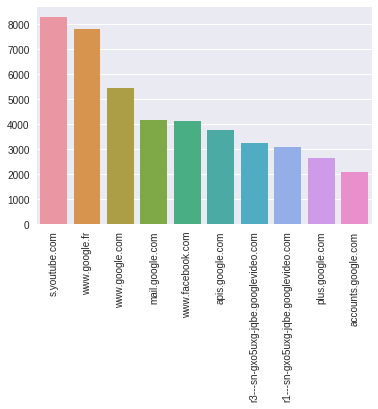

In [22]:
axes = sns.barplot(x=top10_sites, y=top10_freqs)
axes.set_xticklabels(top10_sites, rotation=90)

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [23]:
train_data_10users['session_timespan'].median() 

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [24]:
train_data_10users['day_of_week'].median() 

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [25]:
train_data_150users['start_hour'].median() 

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [26]:
train_data_150users['#unique_sites'].median() 

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [27]:
def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10, window_size=10):
    data_matrix = []
    raw_data = []
    
    file_list = sorted(glob(path_to_csv_files + '/*.csv'))
    
    for f in tqdm(file_list, desc='Read data'):
        data = pd.read_csv(f)
        row = []
        for j, k in zip(data['timestamp'], data['site']):
            row += [(j, k)]
        raw_data += [row]
    
    with open(site_freq_path, 'rb') as f:
        site_dict = pickle.load(f)
    
    for i, v in enumerate(tqdm(raw_data, desc='Create data set')):
        for j in np.arange(0, len(v), window_size):
            row = []
            times = []
            count_popular_10 = 0
            
            for k in np.arange(session_length):
                                
                try:
                    row += [site_dict[v[j+k][1]][0]]
                    
                    if (row[-1] <= 10): count_popular_10 += 1
                    
                    times += [v[j+k][0]]
                
                except:
                    row += [0]
                    
                               
            time_min = datetime.strptime(min(times), '%Y-%m-%d %H:%M:%S')
            time_max = datetime.strptime(max(times), '%Y-%m-%d %H:%M:%S')
            
            session_timespan = (time_max-time_min).seconds
            
            if (0 in row): unique_sites = len(set(row)) - 1
            else: unique_sites = len(set(row))
            
            start_hour = time_min.hour
            
            day_of_week = time_min.date().weekday()
            
            number_sites = np.count_nonzero(np.array(row))
            
            popular_10_proportion = count_popular_10 / number_sites
            
            mean_time_per_site = session_timespan / number_sites
            
            month = time_min.month
            
            year = time_min.year
            
            row += [session_timespan, unique_sites, start_hour, day_of_week, 
                popular_10_proportion, mean_time_per_site, month, year, 
                i+1]
                            
            data_matrix += [row]
                
    data_set = pd.DataFrame (data_matrix, columns=features)
    
    return data_set

In [28]:
feature_names_custom = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 
                 'popular_10_proportion', 'mean_time_per_site', 'month', 'year', 
                 'target']

In [29]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  features=feature_names_custom, session_length=10) 

Create data set: 100%|██████████| 10/10 [00:00<00:00, 14.19it/s]

CPU times: user 912 ms, sys: 56 ms, total: 968 ms
Wall time: 940 ms


In [30]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  features=feature_names_custom, session_length=10)

Create data set: 100%|██████████| 150/150 [00:07<00:00, 20.22it/s]


CPU times: user 9.33 s, sys: 412 ms, total: 9.74 s
Wall time: 9.45 s


In [31]:
with open(os.path.join(PATH_TO_DATA, 
                       'custom_new_features_10users.pkl'), 'wb') as custom_new_features_10users_pkl:
    pickle.dump(new_features_10users, custom_new_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'custom_new_features_150users.pkl'), 'wb') as custom_new_features_150users_pkl:
    pickle.dump(new_features_150users, custom_new_features_150users_pkl, 
                protocol=2)

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [32]:
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

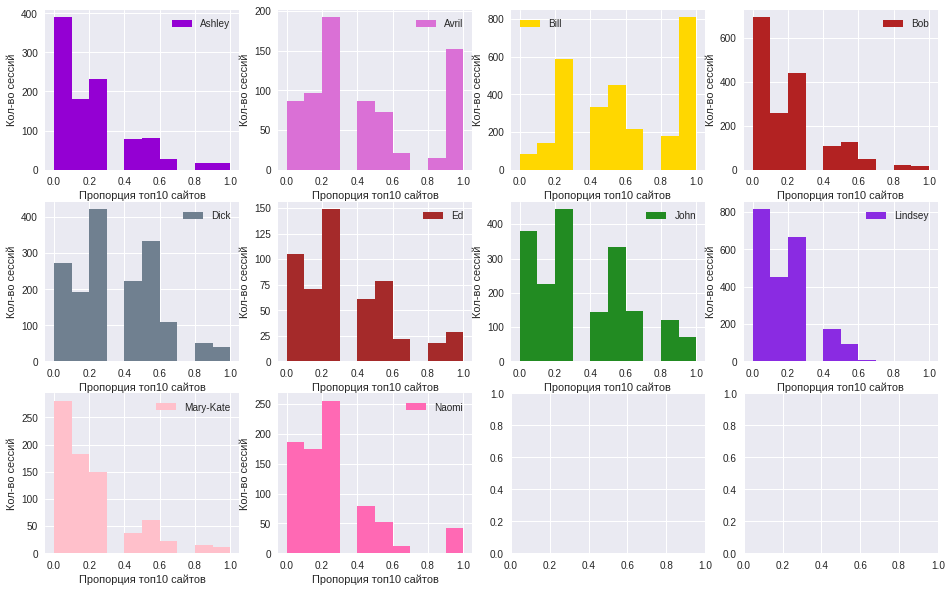

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    axes[idx//4, idx%4].set_ylabel ('Кол-во сессий')
    axes[idx//4, idx%4].set_xlabel ('Пропорция топ10 сайтов')
    sub_df['popular_10_proportion'].hist(ax=axes[idx//4, idx%4], color=color_dic[user], label=user)
    axes[idx//4, idx%4].legend()

Распределения по пользователям отличаются по данному признаку. Может помочь в идентификации.

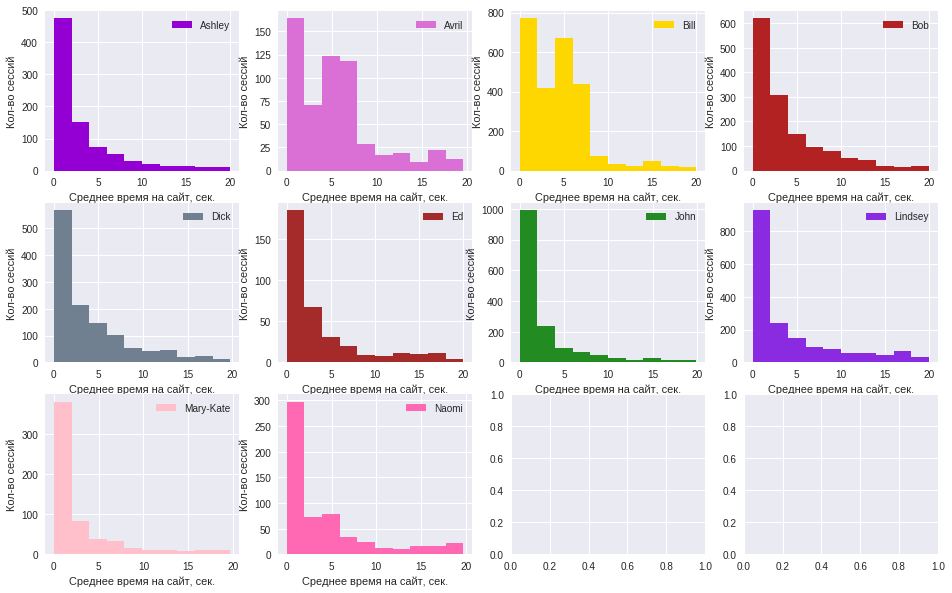

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    axes[idx//4, idx%4].set_ylabel ('Кол-во сессий')
    axes[idx//4, idx%4].set_xlabel ('Среднее время на сайт, сек.')
    sub_df['mean_time_per_site'][sub_df.mean_time_per_site <= 20].hist(ax=axes[idx//4, idx%4],
        color=color_dic[user], label=user)
    axes[idx//4, idx%4].legend()

Распределения более менее значимо отличаются у двух пользователей. Врядли этот признак сильно поможет в идентификации.

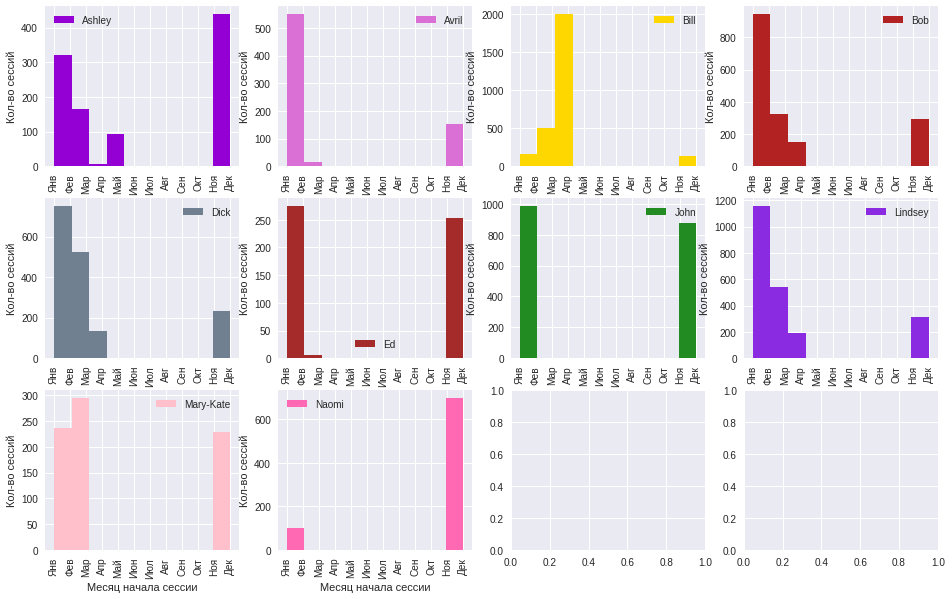

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    axes[idx//4, idx%4].set_ylabel ('Кол-во сессий')
    axes[idx//4, idx%4].set_xlabel ('Месяц начала сессии')
    axes[idx//4, idx%4].set_xticks([i for i in range(1,13)])
    axes[idx//4, idx%4].set_xticklabels(
        ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'],
         rotation=90)
    sub_df['month'].hist(ax=axes[idx//4, idx%4], color=color_dic[user], label=user)
    axes[idx//4, idx%4].legend()

Распределения по пользователям отличаются по данному признаку. Может помочь в идентификации.

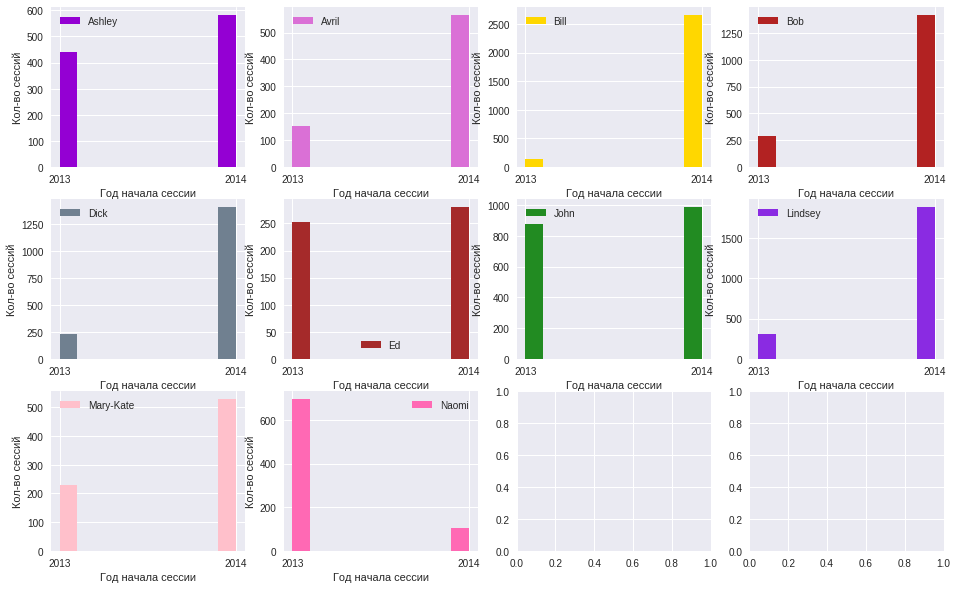

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    axes[idx//4, idx%4].set_ylabel ('Кол-во сессий')
    axes[idx//4, idx%4].set_xlabel ('Год начала сессии')
    axes[idx//4, idx%4].set_xticks([2013, 2014])
    axes[idx//4, idx%4].set_xticklabels(['2013', '2014'])
    sub_df['year'].hist(ax=axes[idx//4, idx%4], color=color_dic[user], label=user)
    axes[idx//4, idx%4].legend()

Признак говорит скорее всего только о периоде сбора данных. Врядли поможет в идентификации 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [37]:
selected_features_names = ['#unique_sites', 'start_hour', 'day_of_week', 'popular_10_proportion', 'month']
selected_features_10users = new_features_10users[selected_features_names] 
selected_features_150users = new_features_150users[selected_features_names]

In [38]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 